# **NLP**

## **Preprocessing**

In [171]:
# # !pip uninstall pandas
# # !pip install pandas==1.1.5
# !pip install pyLDAvis
# !pip install pyLDAvis.gensim
# # !pip install bokeh
# # !pip install gensim
# # !pip install spacy
# !pip install logging
# # !pip install wordcloud
# !pip install nltk
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# # !pip install -U seaborn
# # !pip install translators --upgrade
# # !pip install --upgrade pip

In [172]:
import pandas as pd

df_tweets = pd.read_csv('https://www.ishelp.info/data/tweets_aws.csv')

In [173]:
import sys
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings, en_core_web_sm
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'co', 'aws', 'amazon', 'com', 'cloud', 'https', 'amp', 'http', 'twitter']) # After reviewering the LDA, return to add words that you want to eliminate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Remove retweets
This is optional

In [174]:
print(f'Total tweets: {len(df_tweets)}')
df_originals = df_tweets[~df_tweets['text'].str.contains("RT @")]
print(f'Original tweets: {len(df_originals)}')

Total tweets: 1000
Original tweets: 996


### Tokenize and Clean
Remove line breaks, single quotes, email addresses.
Use Gensim's simple_preprocess to hash/tokenize each string

In [175]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\\S*@\\S*\\s?', '', sent)  # remove emails
        sent = re.sub('\\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert each tweet to a list of cleaned words and add to a master list
data = df_originals.text.values.tolist()
data_words = list(sent_to_words(data))
for tweet in data_words[:5]: # print the first :n tweet word lists
  print(tweet)

['amazon', 'web', 'services', 'is', 'becoming', 'nice', 'predictable', 'profit', 'engine', 'http', 'uk', 'businessinsider', 'com', 'amazon', 'web', 'services', 'profit', 'vs', 'total', 'amazon', 'profit', 'utm_term', 'tech', 'chart', 'of', 'the', 'day', 'rus', 'ir', 'utm_content', 'buffer', 'fd', 'utm_medium', 'social', 'utm_source', 'twitter', 'com', 'utm_campaign', 'buffer', 'http', 'twitter', 'com', 'rhunold', 'status', 'photo']
['announcing', 'four', 'new', 'vpn', 'features', 'in', 'our', 'sao', 'paulo', 'region', 'https', 'aws', 'amazon', 'com', 'about', 'aws', 'whats', 'new', 'new', 'vpn', 'features', 'in', 'sao', 'paulo', 'sc_channel', 'sm', 'sc_campaign', 'launches_', 'sc_publisher', 'tw_go', 'sc_content', 'vpn_sao_paulo', 'sc_country', 'global', 'sc_geo', 'global', 'sc_category', 'vpn', 'adbsc', 'social_', 'http', 'twitter', 'com', 'awscloud', 'status', 'photo']
['are', 'you', 'an', 'user', 'use', 'zadara', 'aws', 'to', 'enahnce', 'your', 'storage', 'just', 'one', 'click', 'aw

In [176]:
length = ''
for i in range(len(data_words)):
    for j in range(len(data_words[i])):
        length += data_words[i][j]
print(f'Corpus size: {str(len(length))}')

Corpus size: 279889


### Add Bigrams, Trigrams, and Stem

In [177]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Remove stop words, add bigrams and trigrams, performed lemmatization/stemming

In [178]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  # Remove stopwords, form bigrams and trigrams, and perform Lemmatization
  texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
  texts = [bigram_mod[doc] for doc in texts]
  texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
  
  texts_out = []
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules
  
  for sent in texts:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
      
  # remove stopwords once more after lemmatization
  texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
  return texts_out

data_ready = process_words(data_words)  # processed Text Data!
for tweet in data_ready[:5]:
  print(tweet)

['web_service', 'become', 'nice', 'predictable', 'profit', 'engine', 'businessinsider', 'web_service', 'profit', 'total', 'profit', 'utm_term', 'tech', 'chart', 'day', 'rus', 'rhunold', 'status_photo']
['announce', 'new', 'vpn', 'feature', 'new', 'vpn', 'feature', 'sao_paulo', 'vpn_sao_paulo', 'sc_category', 'vpn']
['user', 'use', 'click', 'away', 'marketplace', 'seller', 'profile', 'ref', 'dtl_pcp_sold_by', 'utf', 'click', 'zadarastorage', 'status_photo']
['support', 'vpc_nat_gateway', 'support', 'global']
['support', 'vpc_nat_gateway', 'support', 'global']


## **LDA Topic Model: Tweet Text**


### Build an LDA 
Build Latent Dirichlet Allocation model for detecting the top n topics in the corpus

In [179]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
for row in id2word.iteritems():
  print(row)

(0, 'become')
(1, 'businessinsider')
(2, 'chart')
(3, 'day')
(4, 'engine')
(5, 'nice')
(6, 'predictable')
(7, 'profit')
(8, 'rhunold')
(9, 'rus')
(10, 'status_photo')
(11, 'tech')
(12, 'total')
(13, 'utm_term')
(14, 'web_service')
(15, 'announce')
(16, 'feature')
(17, 'new')
(18, 'sao_paulo')
(19, 'sc_category')
(20, 'vpn')
(21, 'vpn_sao_paulo')
(22, 'away')
(23, 'click')
(24, 'dtl_pcp_sold_by')
(25, 'marketplace')
(26, 'profile')
(27, 'ref')
(28, 'seller')
(29, 'use')
(30, 'user')
(31, 'utf')
(32, 'zadarastorage')
(33, 'global')
(34, 'support')
(35, 'vpc_nat_gateway')
(36, 'available')
(37, 'dms')
(38, 'tw_adbpr')
(39, 'aws_infographic')
(40, 'awscloud')
(41, 'celebrate')
(42, 'year')
(43, 'cuenten')
(44, 'movile')
(45, 'operadore')
(46, 'rss')
(47, 'servicio')
(48, 'tre')
(49, 'utm_campaign')
(50, 'utm_medium')
(51, 'awssummitsg')
(52, 'customer')
(53, 'insight')
(54, 'learn')
(55, 'share')
(56, 'bigdata_blog')
(57, 'bigdata_post_tx')
(58, 'blog')
(59, 'import')
(60, 'note')
(61, 'ze

In [180]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 3),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2)],
 [(15, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 3), (21, 1)],
 [(10, 1),
  (22, 1),
  (23, 2),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(33, 1), (34, 2), (35, 1)],
 [(33, 1), (34, 2), (35, 1)],
 [(33, 1), (34, 2), (35, 1)],
 [(19, 1), (36, 1), (37, 1), (38, 1)],
 [(19, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 2)],
 [(43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)],
 [(51, 1), (52, 2), (53, 1), (54, 1), (55, 1)],
 [(17, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1)],
 [(17, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 2),
  (69, 2)],
 [(29, 2),
  (58, 1),
  (70, 2),
  (71, 1),
  (72, 1),
  (73, 2),
  (74, 2),
  (75, 1),
  (76, 2)],
 [(10, 1),
  (77, 1),
  (78, 1),
  (7

In [181]:
# Change the number of topics in the LDA here
topics = 6

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=12345,
                                            chunksize=20,
                                            passes=10,
                                            per_word_topics=True)

ldatopics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics())

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

[(0,
  '0.049*"learn" + 0.034*"tw_adbpl_tw" + 0.029*"route" + 0.025*"location" + '
  '0.023*"webinar" + 0.022*"app" + 0.021*"health" + 0.019*"trkcampaign" + '
  '0.019*"web_service" + 0.017*"day"'),
 (1,
  '0.065*"use" + 0.047*"cloudformation" + 0.028*"api_gateway" + 0.024*"stream" '
  '+ 0.021*"resource" + 0.019*"time" + 0.018*"security" + 0.017*"tag" + '
  '0.016*"fb" + 0.014*"enable"'),
 (2,
  '0.082*"whats_new" + 0.051*"new" + 0.040*"redshift" + 0.031*"console" + '
  '0.030*"cloudcompute" + 0.020*"announce" + 0.017*"fast" + '
  '0.015*"integration" + 0.015*"sc_category" + 0.015*"feature"'),
 (3,
  '0.131*"support" + 0.071*"available" + 0.048*"region" + 0.046*"tw_adbpr" + '
  '0.035*"datum" + 0.031*"sc_category" + 0.031*"rd" + 0.014*"kinesis" + '
  '0.012*"adbsc" + 0.010*"classiclink"'),
 (4,
  '0.045*"service" + 0.033*"iot" + 0.029*"lambda" + 0.020*"splunkevent" + '
  '0.018*"run" + 0.016*"base" + 0.014*"session" + 0.013*"tech" + 0.013*"webex" '
  '+ 0.012*"solution"'),
 (5,
  '0.0

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

### How Many Topics?
One of the primary problems people have when running LDAs is determining the number of topics to build. There is no single rule to always answer this. But there are a few metrics that can help. 

#### Choose the number of topics that has highest coherence / lowest perplexity. Choose the one that has the biggest difference between the coherence and the perplexity.

Coherence is a measure of how close together words are in a topic. How much a topic makes sense.

Perplexity is how dificult it is to differentiate between topics

In [182]:
df_fit = pd.DataFrame(columns=['num_topics', 'perplexity', 'coherence'])

for n in range(3,10):
  # Fit LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              id2word=id2word, 
                                              num_topics=n, 
                                              random_state=12345,
                                              chunksize=100, 
                                              passes=5,
                                              per_word_topics=True)

  # Generate fit metrics
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
  # Add metrics to df_fit
  df_fit.loc[n - 3] = [n, round(lda_model.log_perplexity(corpus), 3), round(coherence_model_lda.get_coherence(), 3)]

df_fit['diff'] = abs(df_fit.coherence - df_fit.perplexity)
df_fit

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

,num_topics,perplexity,coherence,diff
0,3.0,-7.367,0.357,7.724
1,4.0,-7.407,0.419,7.826
2,5.0,-7.424,0.432,7.856
3,6.0,-7.459,0.452,7.911
4,7.0,-7.479,0.471,7.950
5,8.0,-7.507,0.501,8.008
6,9.0,-7.515,0.496,8.011


### Score Topics
What is the Dominant topic and its % contribution in each tweet?

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [183]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              id2word=id2word, 
                                              num_topics=6, 
                                              random_state=12345,
                                              chunksize=100, 
                                              passes=5,
                                              per_word_topics=True)

df = df_tweets.copy()

num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
for col in range(num_topics): # generate a new column for each topic
  df[f'topic_{col + 1}'] = 0.0
  
# Store the topic score and dominant topic
for i, words in enumerate(data_ready):
  doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words
  
  for j, score in enumerate(doc[0]): # for each document in the corpus
    # Get the topic score and store it in the appropriate column
    df.iat[i, (len(df.columns) - ((num_topics) - score[0]))] = score[1]

df_scores = df.copy()
df.head()

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,Male,Monday,23,2,4037,1,52,3.0,Amazon Web Services is becoming a nice predictable profit engine http://uk.businessinsider.com/a...,0.956060,0.000000,0.000000,0.000000,0.000000,0.000000
1,Unknown,Friday,12,4,524418,21,72,0.0,Announcing four new VPN features in our Sao Paulo Region. https://aws.amazon.com/about-aws/whats...,0.013890,0.013898,0.704750,0.013896,0.014116,0.239450
2,Unknown,Tuesday,9,31,1748,1,46,0.0,Are you an @awscloud user? Use #Zadara + #AWS to enahnce your storage just one click away! https...,0.011950,0.012021,0.011940,0.011906,0.940242,0.011941
3,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and Mor...,0.033333,0.033333,0.033333,0.636821,0.033615,0.229564
4,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and Mor...,0.033333,0.033333,0.033333,0.636497,0.033615,0.229888


### Representative Sentence
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [184]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# Create the output DataFrame
df_representative_tweets = pd.DataFrame(columns=df.columns)

# Iterate through each topic
for n in range(1, num_topics + 1):
  # Copy the row from the original df with the highest topic score into the new df
  df_representative_tweets.loc['topic_' + str(n)] = df.loc[df['topic_' + str(n)].idxmax()]

df_representative_tweets

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
topic_1,Unknown,Wednesday,15,8,651699,48,78,0.0,Introducing the AWS Migration Competency! https://aws.amazon.com/blogs/aws/new-aws-competency-aw...,0.960304,0.000000,0.000000,0.000000,0.000000,0.000000
topic_2,Unknown,Friday,10,26,782,2,48,0.0,Continuous Delivery and Effective Feature Flagging with LaunchDarkly AWS Startup Collecti https...,0.000000,0.970199,0.000000,0.000000,0.000000,0.000000
topic_3,Unknown,Tuesday,17,5,564089,29,72,2.0,Download our new whitepaper &amp; learn the benefits of modernizing Your Microsoft apps on AWS. ...,0.000000,0.000000,0.973938,0.000000,0.000000,0.000000
topic_4,Male,Sunday,11,14,864,2,45,0.0,"""#BigData: 35 Brilliant And Free Data Sources For 2016\rhttp://www.forbes.com/sites/bernardmarr/...",0.010510,0.010435,0.010417,0.947805,0.010417,0.010417
topic_5,Male,Wednesday,16,13,5270,2,62,0.0,Check out one of our newest AWS Learning podcasts on welding and additive manufacturing. http://...,0.000000,0.000000,0.000000,0.000000,0.950903,0.000000
topic_6,Female,Thursday,7,31,289,2,39,3.0,Here are Top #Tech Companies Secrets to #Hiring the Best People https://medium.com/conquering-co...,0.000000,0.000000,0.000000,0.000000,0.000000,0.958245


## **Visualize the LDA Topics**

### Frequency Distribution
How many words are in each tweet? When working with a large number of tweets, you want to know how big the tweet are as a whole and by topic. Let’s plot the tweet word counts distribution.

<Figure size 1296x504 with 0 Axes>

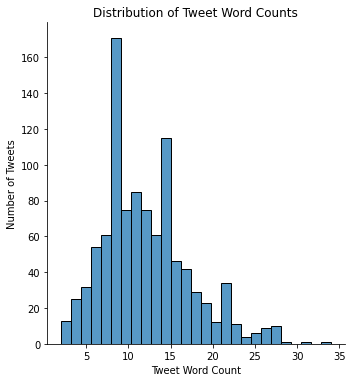

In [185]:
doc_lens = [len(d) for d in data_ready]

plt.figure(figsize=(18,7))
sns.displot(doc_lens, bins=27)
plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

### Clouds of Top N Keywords
Update the max_words variable below to include more or less words per cloud. The coloring of the topics is used in subsequent vizs.

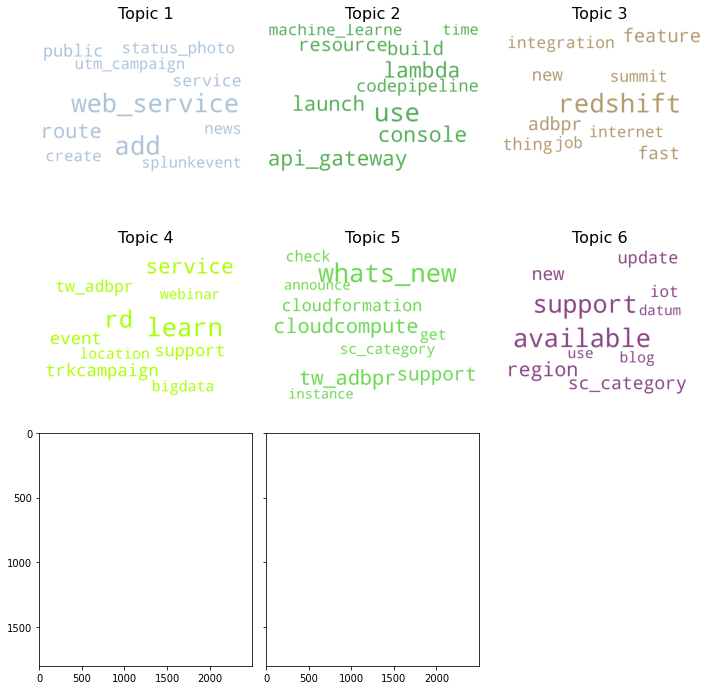

In [186]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors, math

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS', fewer colors: 'mcolors.TABLEAU_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
      plt.gca().axis('off')
    except:
      continue


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Topic Keywords Counts
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the tweets is also interesting to see.

We will plot the word counts and the weights of each keyword in the same chart.

Look for words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important.

#### *remove words that appear accross multiple topics, and words that have a higher word count than weight.

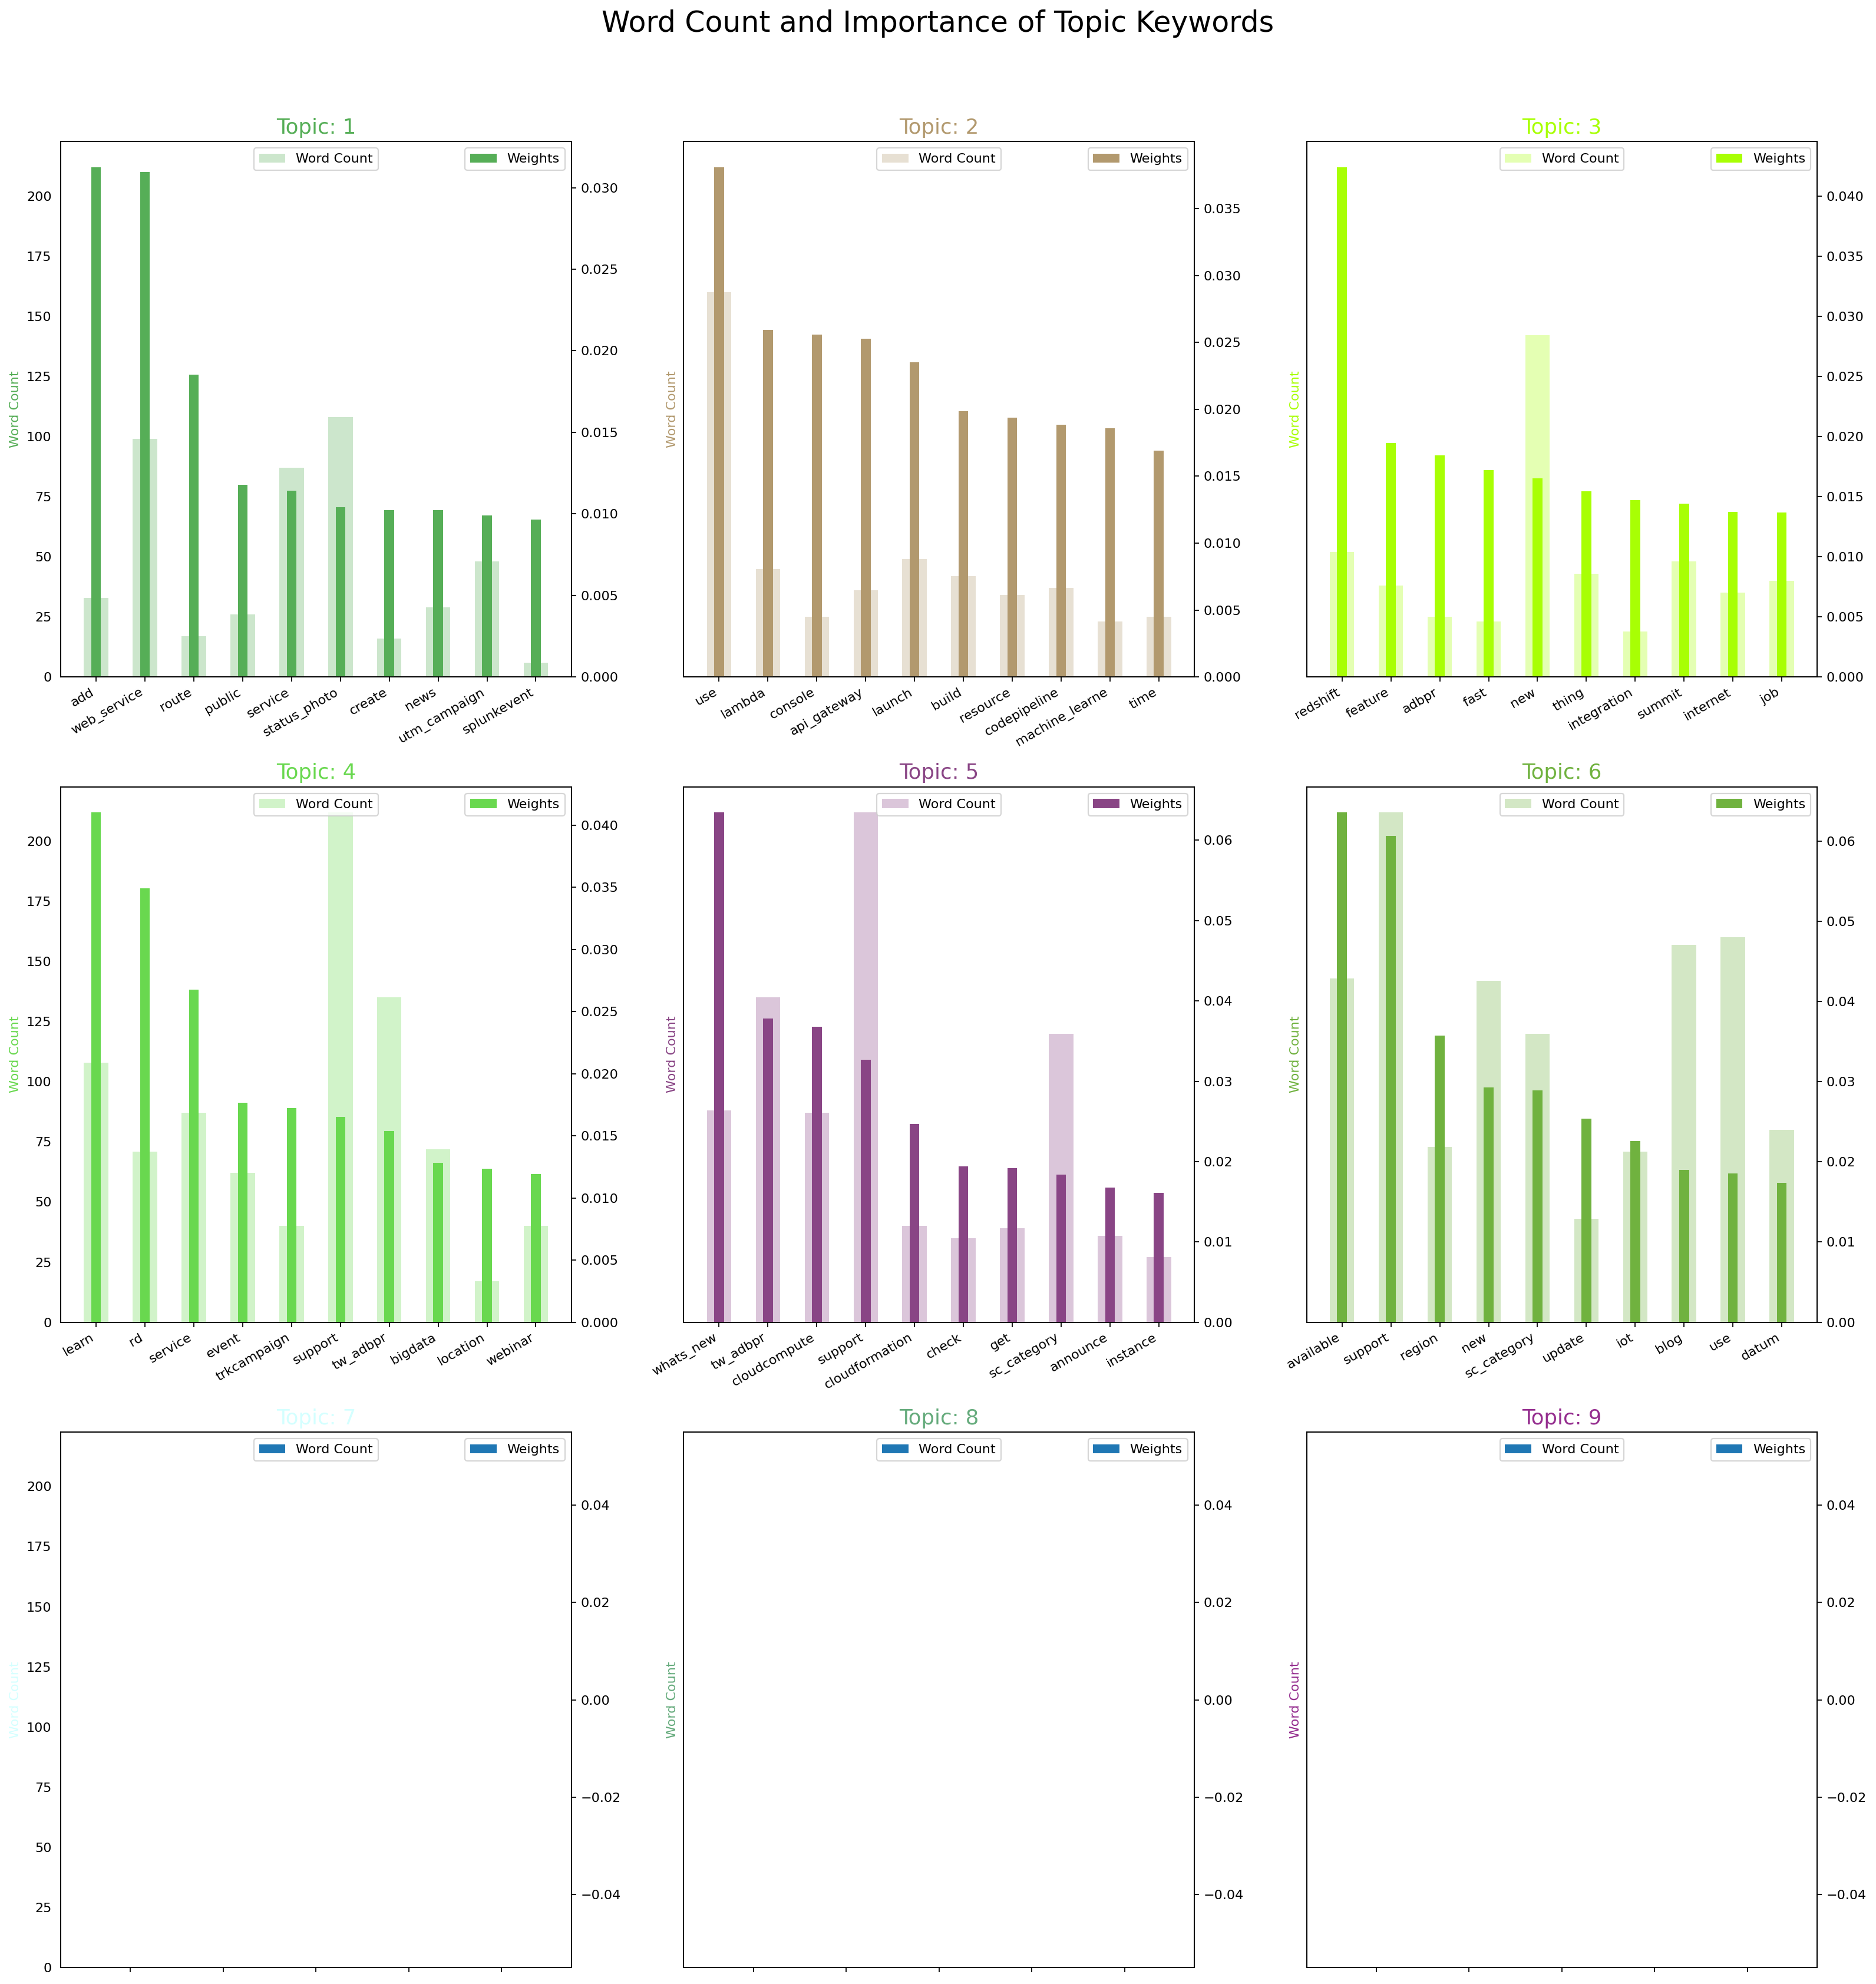

In [187]:
# Bar chart of word counts for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i + 1, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i+1])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i + 1), color=cols[i+1], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i+1, 'word'], rotation=30, horizontalalignment= 'right')
    try:
      ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')
    except:
      pass

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored 
Each word in a tweet is representative of one of the 4 topics. You can color each word in a given tweet by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the tweet.

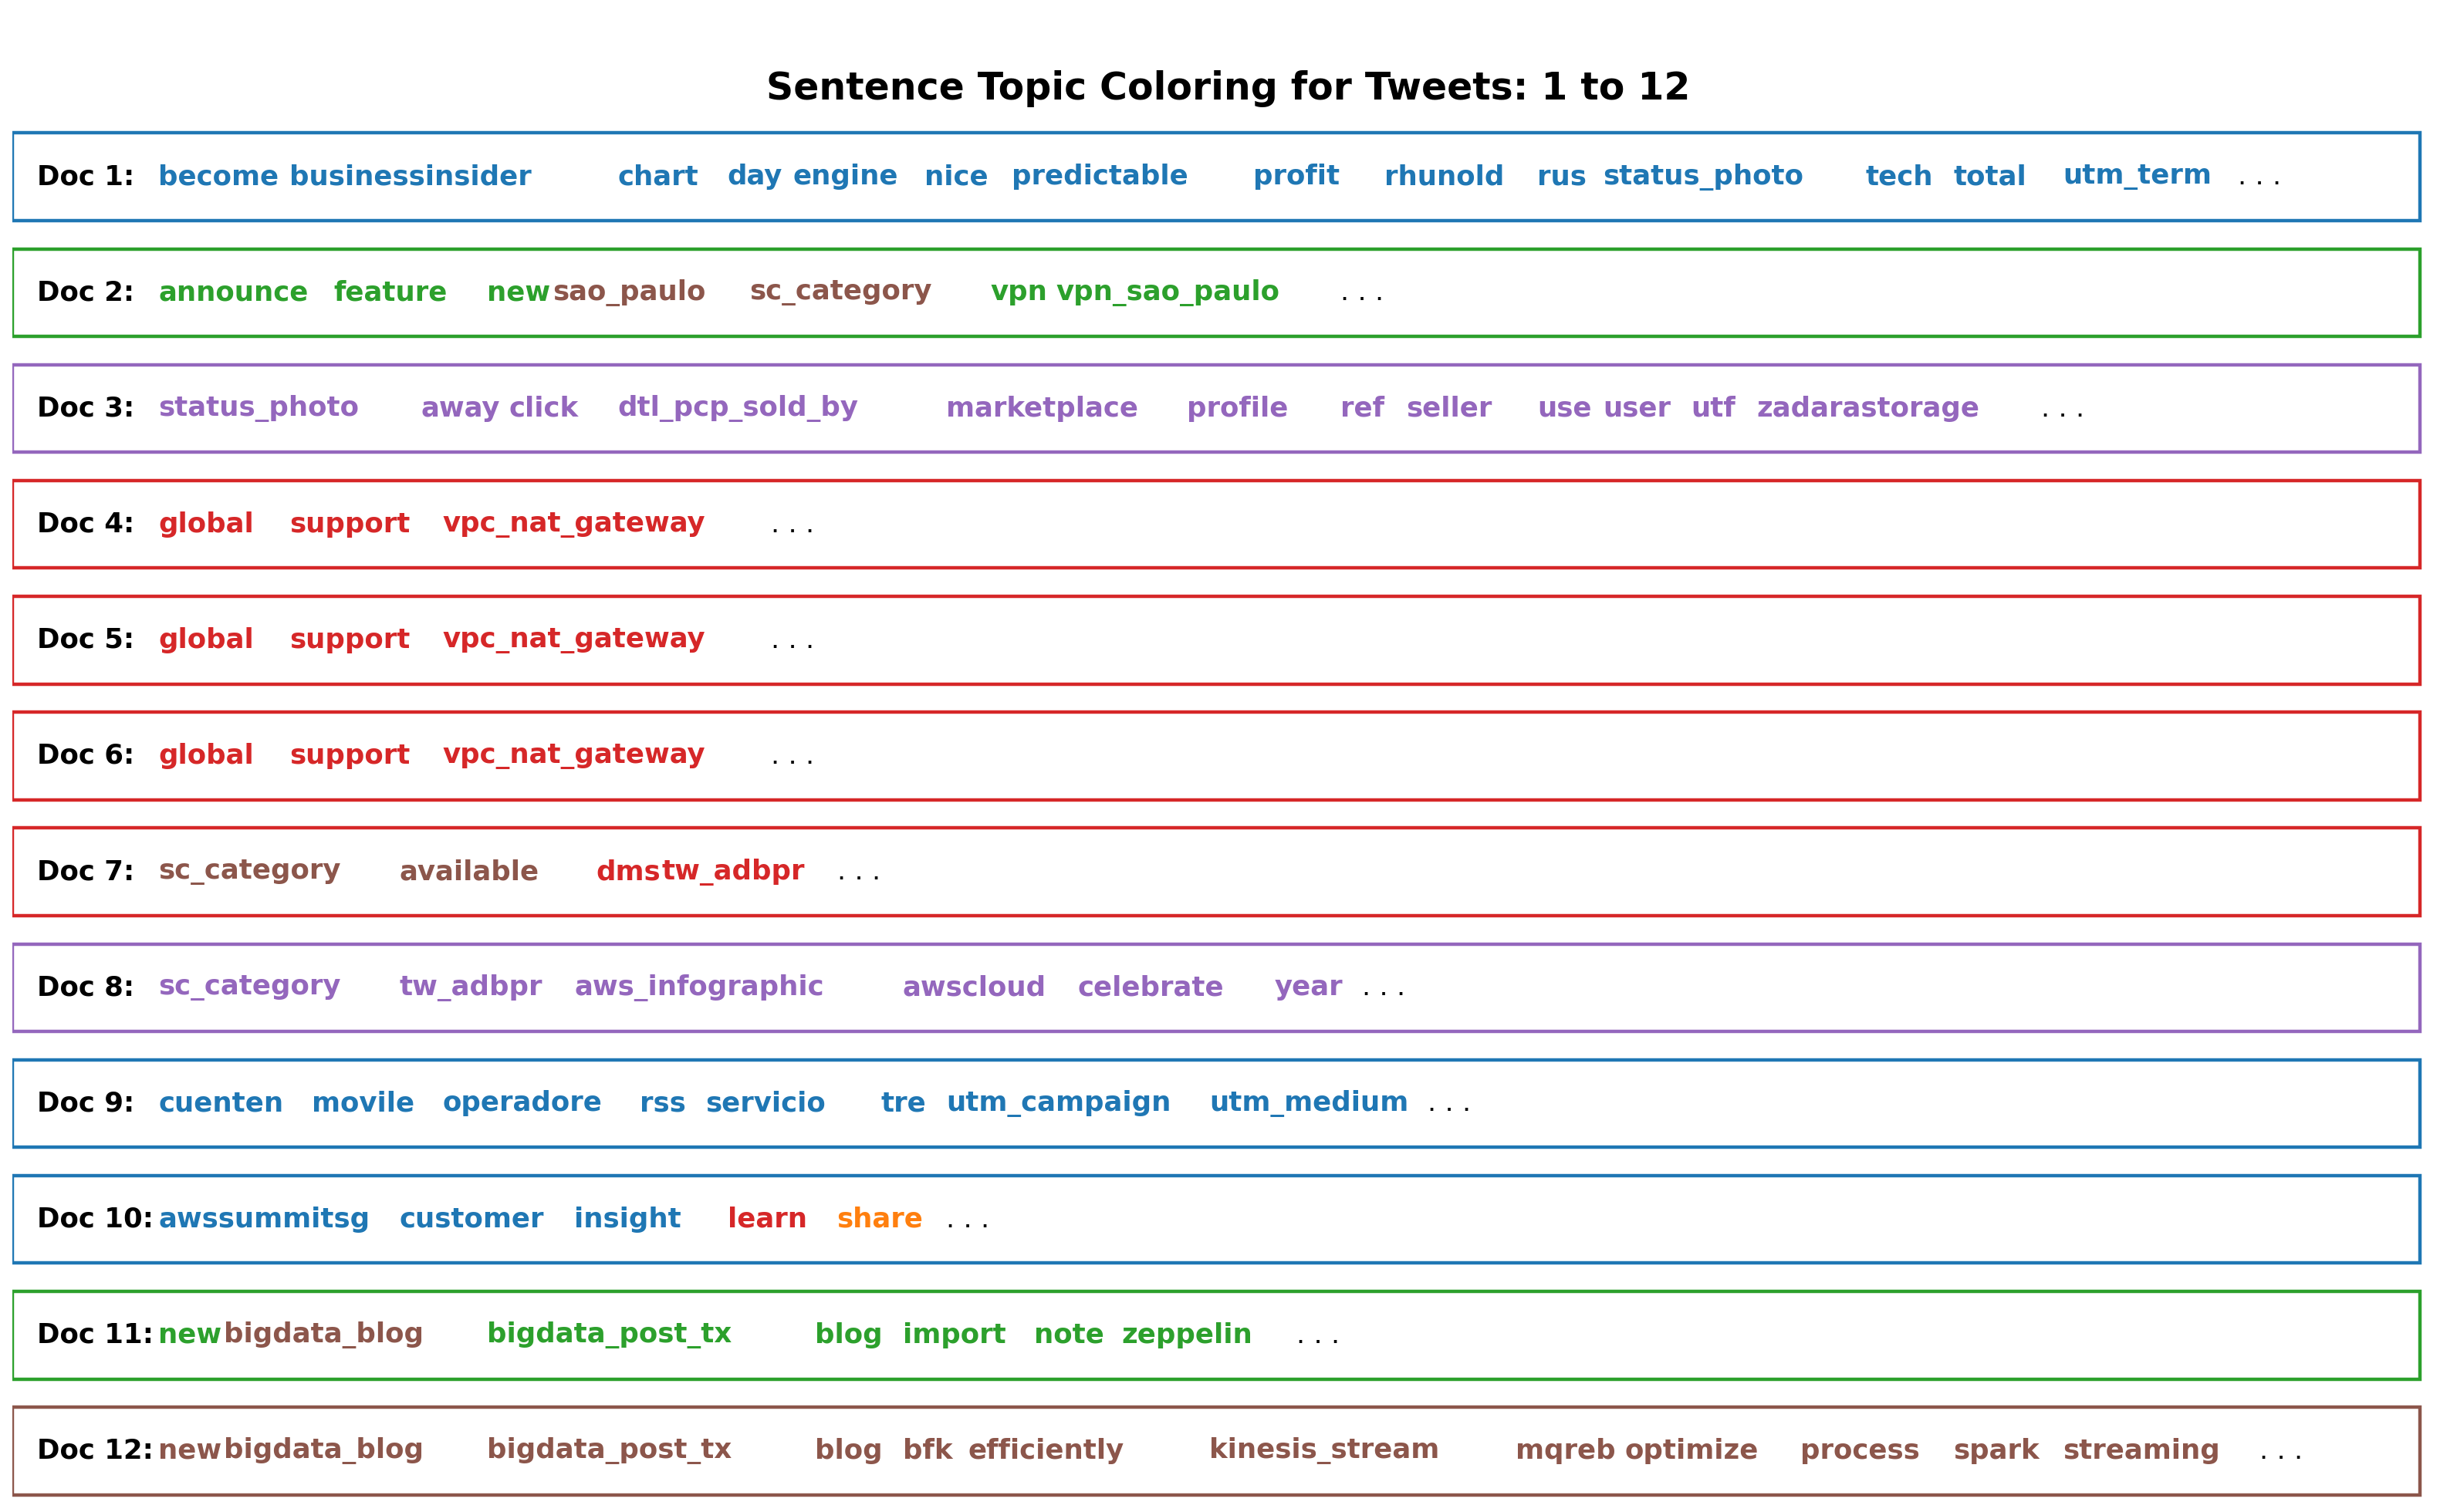

In [188]:
# Sentence Coloring of N Tweets
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Tweets: ' + str(start + 1) + ' to ' + str(end-1), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

### t-SNE Clustering Chart
Compute the total number of tweets attributed to each topic.

In [189]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 979 samples in 0.003s...
[t-SNE] Computed neighbors for 979 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 979 / 979
[t-SNE] Mean sigma: 0.105893


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.932728


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 0.477435


### pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model.

In [190]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.250553 -0.041951       1        1  21.041320
4      0.141756  0.108506       2        1  17.916048
3     -0.116578  0.249471       3        1  17.124730
0     -0.167370 -0.030166       4        1  15.473481
1     -0.004994 -0.105565       5        1  14.391845
2     -0.103366 -0.180295       6        1  14.052576, topic_info=             Term        Freq       Total Category  logprob  loglift
36      available  161.000000  161.000000  Default  30.0000  30.0000
108     whats_new  137.000000  137.000000  Default  29.0000  29.0000
34        support  258.000000  258.000000  Default  28.0000  28.0000
54          learn   85.000000   85.000000  Default  27.0000  27.0000
102      redshift   72.000000   72.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
387          late   10.697626   14.334603   Topic6  -5.0624   1.6697
467      security   12.862424   31.150301   Topic6  -4.8781   1.0779
10   status_photo   13.610490   49.875235   Topic6  -4.8215   0.6637
50     utm_medium   10.982360   31.477181   Topic6  -5.0361   0.9094
58           blog   10.991463  104.306964   Topic6  -5.0353  -0.2879

[272 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
177       2  0.980898          access
316       6  0.916781         account
857       1  0.954811              ad
317       6  0.972713           adbpr
154       1  0.596778           adbsc
...     ...       ...             ...
584       3  0.981497       workspace
109       4  0.768868             www
109       6  0.205032             www
239       4  0.911975      www_google
1307      4  0.982160  www_marketwire

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 4, 1, 2, 3])

In [192]:
import statsmodels.api as sm

df_dummy = pd.get_dummies(df_scores, columns=['Weekday', 'Gender'], drop_first=True)

y = df_dummy.RetweetCount
X = df_dummy.drop(columns=['RetweetCount', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'text']).assign(const=1)

print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetweetCount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     23.24
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           4.51e-52
Time:                        20:41:58   Log-Likelihood:                -4319.5
No. Observations:                1000   AIC:                             8669.
Df Residuals:                     985   BIC:                             8743.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Hour                  0.3033      0.11

In [193]:
X = df_dummy.drop(columns=['RetweetCount', 'text']).assign(const=1)

print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetweetCount   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     16.46
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           4.89e-49
Time:                        20:42:22   Log-Likelihood:                -4317.3
No. Observations:                1000   AIC:                             8677.
Df Residuals:                     979   BIC:                             8780.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Hour                  0.2936      0.11